# Predicting Loan Defaults for LendingClub - Research Question 4

**Research Question 4:** Which features are the best predictors of default?

**Aim**: The aim of this notebook is to apply feature selection methods & algorithms to identify which subset of features can predict defaults with the highest prediction performance. 

## Table of contents

1. Filter methods to remove features with no predictive power.
2. Preparing features for feature selection using Machine Learning Algorithms.
2. Ranking & selecting features using Random Forests. 
5. Evaluation of feature selection performance using a k-NN classifier.
7. Conclusion.

## Package Requirements

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

## Filter methods to remove features with no predictive power.

**Aim**: The aim of this section is to remove features that have no predictive power and provide very little variability.

### Constant features

In the section below the constant features are identified and filtered:

- Constant features are those features that have only one value for the entire dataset.

In [2]:
#Reading the data

df = pd.read_csv('loan_analysis.csv')

In [3]:
#Dropping the features that are not numerical

df1 = df.loc[:, df.dtypes == float]
df2 = df.loc[:, 'default']
             
#Joining the int and float dataframes together

df_numeric = pd.concat([df1, df2], axis = 1)

#Dropping all NaN rows

df_numeric = df_numeric.dropna()

** Separating the data into training and testing sets**

In [4]:
#Splitting into training and test sets

X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop(labels = ['default'], axis = 1), df_numeric['default'], test_size = 0.3, random_state = 0)

**Variance Threshold function to remove features with 0 variance**

In [5]:
zero_variance = VarianceThreshold(threshold = 0)

#Finding features with 0 variance

zero_variance.fit(X_train)

VarianceThreshold(threshold=0)

In [6]:
#Printing out the number of features that are constant

print(len([feature for feature in X_train.columns if feature not in X_train.columns[zero_variance.get_support()]]))

1


In [7]:
#Printing out the name of the feature

[feature for feature in X_train.columns if feature not in X_train.columns[zero_variance.get_support()]]

['policy_code']

In [8]:
#Verifying that 'policy_code' has no unique values

df['policy_code'].value_counts()

1.0    256939
Name: policy_code, dtype: int64

From the output above:

- Since policy code has only 1 value it is a constant feature with 0 variance and as a result will not provide any value to predicting defaults. 
- Hence policy code will be dropped.

In [9]:
#Dropping policy code from the data 

df = df.drop('policy_code', axis = 1)

### Quasi-Constant features

In the section below the quasi-constant features are identified and filtered:

- Quasi-constant features are those features in which the same value for a majority of rows and thus provide little information for the machine learning model.

**Variance Threshold function to remove features with 0.01 variance.**

In [10]:
quasi_variance = VarianceThreshold(threshold = 0.01)

#Finding features with 0 variance

quasi_variance.fit(X_train)

VarianceThreshold(threshold=0.01)

In [11]:
#Printing out the number of features that are quasi-constant

print(len([feature for feature in X_train.columns if feature not in X_train.columns[quasi_variance.get_support()]]))

2


In [12]:
#Printing out the name of the features

[feature for feature in X_train.columns if feature not in X_train.columns[quasi_variance.get_support()]]

['policy_code', 'acc_now_delinq']

In [13]:
#Verifying that 'acc_now_delinq' has majority constant values

df['acc_now_delinq'].value_counts()

0.0    256194
1.0       703
2.0        36
3.0         3
5.0         2
4.0         1
Name: acc_now_delinq, dtype: int64

From the output above:

- The majority (99% +) of the values in 'acc_now_deliq' is 0.0
- Thus, this feature is quasi-constant and will provide little to almost no value to the machine learning algorithm.

In [14]:
#Dropping 'acc_now_deliq' from the data

df = df.drop('acc_now_delinq', axis = 1)

**Categorical Quasi-constant feature: Application Type**

- The application type is a categorical feature that is quasi-constant in nature.

In [15]:
df['application_type'].value_counts()

INDIVIDUAL    256938
JOINT              1
Name: application_type, dtype: int64

From the output above

- The 'INDIVIDUAL' category makes up all of the feature except for one.
- Thus 99% + of the feature belong to one category alone.
- Thus, this feature provides little value to the machine learning model.

In [16]:
df = df.drop('application_type', axis = 1)

### Duplicated features

In the section below the duplicated features are identified and filtered:

- Duplicated features are those pair of features in which each observation between the two features are identical in every possible way. 
- This means that each observation in the same index will have the same value in both features.
- Thus dropping the second feature that is identical to the first will provide value in terms of dimensionality reduction & removing redundancy. 

In [17]:
#Creating a list to store the duplicated features

duplicate_features = []

for feature in range(0, len(X_train.columns)):
    
    first_feature = X_train.columns[feature]
    
    for second_feature in X_train.columns[feature + 1:]:
        
        #Check if the features have the same value in every row
        
        if X_train[first_feature].equals(X_train[second_feature]):
            
            #Print the feature names
            
            print(first_feature)
            print(second_feature)
            print()
            
            #Append the duplicated feature to the list created initially 
            
            duplicate_features.append(second_feature)

In [18]:
#Printing out the duplicated features

duplicate_features

[]

From the output above:

- There is no feature that shares identical values with another feature in the dataset.

### Correlated Features

In the section below:

- The features that are highly correlated between themselves are filtered as they provide little to no information to the final classifier. 
- The features that are not correlated to the target variable are filtered as they provide little to no information to the final classifier.

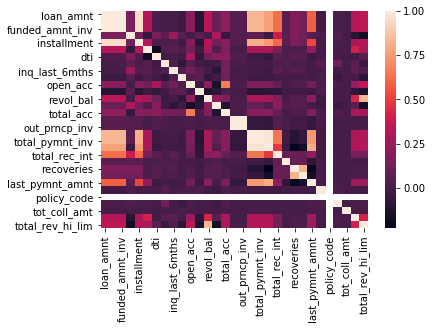

In [19]:
#Visualizing the correlated features

correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix)

From the plot above:

- The diagonal is light red/white which indicates that each feature is highly correlated with itself and thus has a pearson correlation coefficient of -1.
- There are a couple of feature pairs that are highly correlated with each other outside the diagonal which requires further investigation.

In [20]:
#Creating a function to remove the highly correlated features 

def corr_features(dataframe, correlation_coeff):
    
    #Creating a set of correlated feature names
    correlated_features = set() 
    #Creating a correlation matrix
    correlation_matrix = dataframe.corr()
    #Looping over the features in the correlation matrix
    for features in range(len(correlation_matrix.columns)):
        for feature in range(features):
            if abs(correlation_matrix.iloc[features, feature]) > correlation_coeff:
                feature_name = correlation_matrix.columns[features]
                correlated_features.add(feature_name)
                
    return correlated_features

In [21]:
#applying the function in order to identify correlated features with a pearson correlation coefficient > 0.8

correlated_features = corr_features(X_train, 0.8)
len(set(correlated_features))

9

In [22]:
correlated_features

{'collection_recovery_fee',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rev_hi_lim'}

In [23]:
#Dropping the highly correlated features from the dataframe

df = df.drop(labels = correlated_features, axis = 1)

From the output above:
    
- Identified features that were highly correlated with another feature in the dataset (Pearson correlation coefficient > 0.8) 
- The number of features that met this threshold was 9.

### Univariate ROC-AUC score to filter features

In the section below:

- A decision tree classifier is fit for each feature in the data set and an roc-auc score is computed for each feature.
- The roc-auc scores of each feature in the data is evaluated and features that are above a good roc-auc threshold are selected.

In [24]:
#Empty list to store roc-auc score of each feature 

roc_auc_scores = []

#Looping over each feature and fitting a classifier and computing the prediction roc-auc score 

for feature in X_train.columns:
    
    DT_classifier = DecisionTreeClassifier()
    DT_classifier.fit(X_train[feature].fillna(0).to_frame(), y_train)
    target_score = DT_classifier.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_auc_scores.append(roc_auc_score(y_test, target_score[:, 1]))

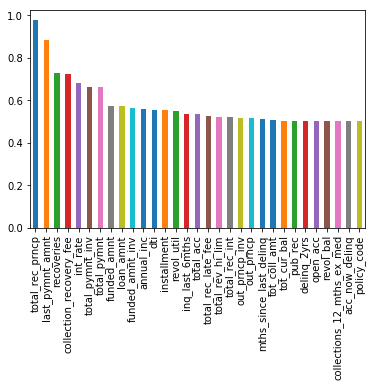

In [25]:
#Creating a bar plot in order to visualize the roc-auc scores

#Converting the roc-auc scores to a series

roc_auc_scores = pd.Series(roc_auc_scores)

#Creating a bar plot to visualize the scores

roc_auc_scores.index = X_train.columns

roc_auc_scores.sort_values(ascending=False).plot.bar()

In [26]:
bad_features = roc_auc_scores[roc_auc_scores < 0.5]
bad_features

Series([], dtype: float64)

From the output above:

- Since all the features perform better than a random prediction (roc-auc score < 0.5) none of the features are filtered and removed using the univariate roc-auc filter method.

## Preparing features for feature selection using Machine Learning Algorithms

**Aim**: The aim of this section is to prepare features for feature selection using Machine Learning Algorithms:

- Removing features with redundant information
- Converting features with dates to a numeric value that can be interpreted by the machine learning model.
- Handling features with missing values
- Integer encoding the ordinal categorical features
- One hot encoding the nominal categorical features

### Features with redundant information

In the section below:

- Features that provide no predictive value such as the ID of each borrower is filtered and removed.
- This provides dimensionality reduction

**member_id**

- The 'member_id' is a feature that gives each borrower a unique identifier. 
- Since identifiers do not add value to the machine learning model the feature is dropped from the dataframe.

In [27]:
df = df.drop('member_id', axis = 1)

**loan_status**

- The 'loan_status' is a feature that has already been encoded as 'default' this feature now becomes duplicated and therefore redundant

In [28]:
df = df.drop('loan_status', axis = 1)

**Index Column**

- The index column is a feature that gives each row a unique number.
- Since identifiers do not add value to the machine learning model the feature is dropped from the dataframe.

In [29]:
df = df.drop('Unnamed: 0', axis = 1)

**next_pymnt_d: Next payment date**

- This feature only contains 1.5% of the total values in the dataset.
- Since 98.5% of the values are missing this feature becomes redundant and does not add logical value to the machine learning model.

In [30]:
df = df.drop('next_pymnt_d', axis = 1)

**title**

- The 'title' is a feature that has already been encoded as 'purpose'.
- This feature now becomes duplicated and therefore redundant.

In [31]:
df = df.drop('title', axis = 1)

**emp_title: Employment title**

- The employment title is a feature that has over 50 unique titles for the borrower based on the nature of employment.
- As these titles have different incomes based on a range of factors such as the company, years of experience they do not inheriently have meaning to the machine learning model.
- A better feature that can predict loan defaults is the annual income of the borrower which correlates better with default prediction and has meaning. 
- Thus the title of employment is a redundant feature that only has a lot of texual information without numeric value.

In [32]:
df = df.drop('emp_title', axis = 1)

From the output above:
    
- The dataset is now left with 35 features.

### Features with dates

In the section below:

- The dates are converted into a numeric format that can be interpreted by the machine learning model.

**Earliest Credit Line**

- The earliest credit line is converted into a integer that represents the number of years the earliest credit line was opened for the borrower.
- *Earliest Credit Line (Years) = 2018 - Year in which the credit line was opened*

In [33]:
#Cleaning the column to include only the years

df['earliest_cr_line'] = df['earliest_cr_line'].str[4:]

#Removing unwanted text

df = df[df.earliest_cr_line.str.contains("ction") == False]

#Converting the column elements into integers

df['earliest_cr_line'] = df['earliest_cr_line'].astype('int64')

#Subracting the current year 2018 from each element 

df['earliest_cr_line'] = (2018 - df['earliest_cr_line'])

warnings.filterwarnings('ignore')

**Issue Date**

- The issue date is converted into a integer that represents the number of years the loan was issued to the borrower.
- *Issue date (Years) = 2018 - Year in which the loan was issued*

In [34]:
#Cleaning the column to include only the years

df['issue_d'] = df['issue_d'].str[4:]

#Removing unwanted text

df = df[df.issue_d.str.contains("ction") == False]

#Converting the column elements into integers

df['issue_d'] = df['issue_d'].astype('int64')

#Subracting the current year 2018 from each element 

df['issue_d'] = (2018 - df['issue_d'])

warnings.filterwarnings('ignore')

**Last Payment Date**

- The last payment date is converted into a integer that represents the number of years since the last payment was made by the borrower.
- *Last payment date (Years) = 2018 - Year in which the last payment was made by the borrower*

In [35]:
#Filling the NaN's with 3, 3 is the most common value for the last payment date 

df['last_pymnt_d'] = df['last_pymnt_d'].fillna(3)

#Cleaning the column to include only the years

df['last_pymnt_d'] = df['last_pymnt_d'].str[4:]

#Removing unwanted text

df = df[df.last_pymnt_d.str.contains("ction") == False]

#Converting the column elements into integers

df['last_pymnt_d'] = df['last_pymnt_d'].astype('int64')

#Subracting the current year 2018 from each element 

df['last_pymnt_d'] = (2018 - df['last_pymnt_d'])

warnings.filterwarnings('ignore')

**Last Credit Pull Date**

- The last credit pull date is converted into a integer that represents the number of years since the last credit was pulled by the borrower.
- *Last credit pull date (Years) = 2018 - Year in which the last credit was pulled by the borrower*

In [36]:
#Filling the NaN's with 2 as 2 is the most common value for the last credit pull date 

df['last_credit_pull_d'] = df['last_credit_pull_d'].fillna(2)

#Cleaning the column to include only the years

df['last_credit_pull_d'] = df['last_credit_pull_d'].str[4:]

#Removing unwanted text

df = df[df.last_credit_pull_d.str.contains("ction") == False]

#Converting the column elements into integers

df['last_credit_pull_d'] = df['last_credit_pull_d'].astype('int64')

#Subracting the current year 2018 from each element 

df['last_credit_pull_d'] = (2018 - df['last_credit_pull_d'])

warnings.filterwarnings('ignore')

### Features with missing values

In the section below:

- Features with missing values are handled with appropriate imputation strategies.

In [37]:
#Extracting features and the number of missing values.

missing_features = df.isnull().sum()
missing = missing_features[missing_features > 0]
missing

emp_length       9965
tot_coll_amt    66329
tot_cur_bal     66329
dtype: int64

From the output above:

- There are 3 features with missing values 

**Feature 1: tot_coll_amt**

In [38]:
df['tot_coll_amt'].value_counts()

0.0        168190
50.0          349
100.0         304
75.0          239
150.0         142
200.0         130
80.0          124
55.0          122
60.0          116
90.0          114
70.0          113
85.0          106
65.0           99
79.0           89
54.0           89
95.0           89
69.0           85
58.0           83
53.0           82
66.0           80
78.0           80
77.0           79
71.0           79
250.0          78
86.0           78
72.0           77
56.0           77
59.0           75
300.0          75
63.0           75
            ...  
1843.0          1
15309.0         1
2534.0          1
4809.0          1
1915.0          1
2405.0          1
6736.0          1
1167.0          1
5603.0          1
1482.0          1
3431.0          1
1956.0          1
4815.0          1
2190.0          1
8520.0          1
3862.0          1
2409.0          1
7978.0          1
6928.0          1
1761.0          1
4024.0          1
8984.0          1
2411.0          1
3661.0          1
6932.0    

From the output above:

- Since the majority of the values are 0 (65%) imputing the missing values with 0 makes the most logical sense.

In [39]:
#Imputing the missing values with 0

df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)

**Feature 2: tot_cur_bal**

In [40]:
df['tot_cur_bal'].value_counts()

0.0         48
25341.0      9
28674.0      9
4875.0       9
30491.0      9
13530.0      9
19376.0      9
27222.0      8
13721.0      8
26201.0      8
15043.0      8
22060.0      8
25443.0      8
13166.0      8
30652.0      8
12022.0      8
21944.0      8
11329.0      8
16709.0      8
15886.0      8
45492.0      8
18311.0      8
17382.0      7
193847.0     7
9958.0       7
16054.0      7
29288.0      7
26302.0      7
14186.0      7
30092.0      7
            ..
40595.0      1
144459.0     1
326620.0     1
186229.0     1
253298.0     1
457679.0     1
132380.0     1
163302.0     1
326591.0     1
43526.0      1
57207.0      1
163293.0     1
24437.0      1
158972.0     1
15445.0      1
326589.0     1
228831.0     1
112829.0     1
503538.0     1
280472.0     1
1015.0       1
223055.0     1
7662.0       1
326596.0     1
110408.0     1
228835.0     1
52231.0      1
163332.0     1
248875.0     1
49152.0      1
Name: tot_cur_bal, Length: 135093, dtype: int64

From the output above:
    
- Since there is no value that stands out as the majority, imputing the missing values with the mean makes the most logical sense.

In [41]:
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(df['tot_cur_bal'].mean())

**Feature 3: emp_length**

In [42]:
df['emp_length'].value_counts()

10+ years    77589
2 years      23937
< 1 year     21376
3 years      20702
5 years      18257
1 year       17254
4 years      16429
6 years      14929
7 years      14223
8 years      12004
9 years       9675
Name: emp_length, dtype: int64

From the output above:
    
- The feature can be converted into a numerical data type instead of object.
- Once converted the missing values can then be imputed using the mean of the feature as there is no single majority value. 

In [43]:
#Data cleaning ot convert the strings to numeric

df['emp_length'] = df['emp_length'].str.replace('+', '')
df['emp_length'] = df['emp_length'].str.replace('year$', '')
df['emp_length'] = df['emp_length'].str.replace('years', '')
df['emp_length'] = df['emp_length'].str.replace('<', '')
df['emp_length'] = df['emp_length'].str.replace(' 1', '0')

In [44]:
#Computing the mean of the feature 

mean = ((10 * 77589) + (2 * 23937) + (3 * 20702) + (5 * 18257)  + (1 * 17254) + (4 * 16429) + (6 * 14929) + 
(7 * 14223) + (8 * 12004) + (9 * 9675))/246375
mean

5.813767630644343

In [45]:
#Filling the missing values with the mean

df['emp_length'] = df['emp_length'].fillna('6')

In [46]:
#Converting the feature to a numeric data type

df['emp_length'] = df['emp_length'].astype('int64')

In [47]:
df['emp_length'].value_counts()

10    77589
6     24894
2     23937
0     21376
3     20702
5     18257
1     17254
4     16429
7     14223
8     12004
9      9675
Name: emp_length, dtype: int64

### One-hot encoding the categorical features

In the section below: 

- The features that are of the 'object' type and are categorical in nature are identified and one-hot encoded so that they can be fit into the machine learning model.
- Features of the 'object' type and are 'numerical' in nature are identified and converted into numerical.. 

In [48]:
#Storing the categorical features into a list

categorical_variables = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 
                        'addr_state', 'initial_list_status']

#Converting the features to categorical

for feature in categorical_variables:
    df[feature] = df[feature].astype('category')

In [49]:
#Converting the 'term' feature to numerical

df['term'] = df['term'].str.replace('months', '')

In [50]:
df['term'] = df['term'].astype('int64')

**Integer Encoding the ordinal categorical variables**

In [51]:
#Encoding the categorical variables into numbers

grade_encode = LabelEncoder()
sub_grade_encode = LabelEncoder()
home_ownership_encode = LabelEncoder()
verification_status_encode = LabelEncoder()
pymnt_plan_encode = LabelEncoder()
purpose_encode = LabelEncoder()
addr_state_encode = LabelEncoder()
initial_list_status_encode = LabelEncoder()

The two ordinal variables are:

- Loan Grade
- Loan Subgrade 
- These variables have an order to them as the loan grade A is the best grade, B is the second best and so on.

In [52]:
df['grade'] = grade_encode.fit_transform(df.grade)
df['sub_grade'] = sub_grade_encode.fit_transform(df.sub_grade)

**One-hot encoding the ordinal categorical variables**

In [53]:
#Encoding the categorical variables into numeric values

df['home_ownership'] = home_ownership_encode.fit_transform(df.home_ownership)
df['verification_status'] = verification_status_encode.fit_transform(df.verification_status)
df['pymnt_plan'] = pymnt_plan_encode.fit_transform(df.pymnt_plan)
df['purpose'] = purpose_encode.fit_transform(df.purpose)
df['addr_state'] = addr_state_encode.fit_transform(df.addr_state)
df['initial_list_status'] = initial_list_status_encode.fit_transform(df.initial_list_status)

In [54]:
#One hot encoding the nominal variables

home_ohe = OneHotEncoder()
verification_ohe = OneHotEncoder()
pymnt_ohe = OneHotEncoder()
purpose_ohe = OneHotEncoder()
addr_ohe = OneHotEncoder()
initial_ohe = OneHotEncoder()

In [55]:
var1 = home_ohe.fit_transform(df.home_ownership.values.reshape(-1,1)).toarray()
var2 = verification_ohe.fit_transform(df.verification_status.values.reshape(-1,1)).toarray()
var3 = pymnt_ohe.fit_transform(df.pymnt_plan.values.reshape(-1,1)).toarray()
var4 = purpose_ohe.fit_transform(df.purpose.values.reshape(-1,1)).toarray()
var5 = addr_ohe.fit_transform(df.addr_state.values.reshape(-1,1)).toarray()
var6 = initial_ohe.fit_transform(df.initial_list_status.values.reshape(-1,1)).toarray()

In [56]:
#Adding the one hot encoded variables to the dataset 

ohe_variable = pd.DataFrame(var1, columns = ["home_ownership_"+str(int(i)) for i in range(var1.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [57]:
ohe_variable = pd.DataFrame(var2, columns = ["verification_status_"+str(int(i)) for i in range(var2.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [58]:
ohe_variable = pd.DataFrame(var3, columns = ["pymnt_plan_"+str(int(i)) for i in range(var3.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [59]:
ohe_variable = pd.DataFrame(var4, columns = ["purpose_"+str(int(i)) for i in range(var4.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [60]:
ohe_variable = pd.DataFrame(var5, columns = ["addr_state_"+str(int(i)) for i in range(var5.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [61]:
ohe_variable = pd.DataFrame(var6, columns = ["initial_list_status_"+str(int(i)) for i in range(var6.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [62]:
#Dropping the categorical columns that have been one-hot encoded

columns_to_drop = ['home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status']
df = df.drop(columns_to_drop, axis = 1)

In [63]:
#Dropping NaNs introduced after one-hot encoding 

df = df.dropna()

**Dividing the data into training and test sets**

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=['default'], axis=1),
                                                    df['default'],test_size=0.3,random_state=42)

## Ranking and selecting features using Random Forests

In the section below

- The features are ranked according to importance using Random Forests. 

In [65]:
#The random forest with 100 trees & selecting the top 10 features

best_features = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=10)

In [66]:
#Fitting the random forest to the training data

best_features.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=10, step=1, verbose=0)

**The top 10 predictors of default.**

In [67]:
top_10 = X_train.columns[(best_features.get_support())]

In [68]:
top_10

Index(['loan_amnt', 'int_rate', 'sub_grade', 'issue_d', 'total_rec_int',
       'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'tot_cur_bal'],
      dtype='object')

From the Random Forest Classifier, the top 10 features that predict default using a recursive feature elimination strategy are as follows:

1. Loan Amount
2. Interest Rate
3. Loan Sub-Grade
4. Loan Issue Date
5. Interest Recieved till date 
6. Post charge off gross recovery
7. Last payment date 
8. Last payment amount
9. The most recent month Lending Club pulled credit for the loan
10. The total current balance of all accounts of the borrower.

## Evaluation of feature selection performance using a k-NN Classifier

**Aim**: The section aims to evaluate the performance of a k-NN on the data post feature selection and as such has two main aims:

- Understanding if feature selection improves the prediction performance using a k-Nearest Neighbour classifier. 
- Understanding the optimal number of features that provide the best prediction performance.

*The k-Nearest Neighbour classifer is chosen as it is not a tree based classifier. Since feature selection was performed using a tree based classifier, i.e The Random Forest, using another tree based classifier to evaluate the performance of feature selection may give biased results.*

**Top 20 features**

In [69]:
#The random forest with 100 trees & selecting the top 20 features

best_features_20 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=20)

#Fitting the random forest to the training data

best_features_20.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=20, step=1, verbose=0)

In [70]:
top_20 = X_train.columns[(best_features_20.get_support())]

**Top 30 features**

In [71]:
#The random forest with 100 trees & selecting the top 30 features

best_features_30 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=30)

#Fitting the random forest to the training data

best_features_30.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=30, step=1, verbose=0)

In [72]:
top_30 = X_train.columns[(best_features_30.get_support())]

**Top 40 features**

In [73]:
#The random forest with 100 trees & selecting the top 30 features

best_features_40 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=40)

#Fitting the random forest to the training data

best_features_40.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=40, step=1, verbose=0)

In [74]:
top_40 = X_train.columns[(best_features_40.get_support())]

**Top 50 features**

In [75]:
#The random forest with 100 trees & selecting the top 30 features

best_features_50 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=50)

#Fitting the random forest to the training data

best_features_50.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=50, step=1, verbose=0)

In [76]:
top_50 = X_train.columns[(best_features_50.get_support())]

**Top 60 features**

In [77]:
#The random forest with 100 trees & selecting the top 30 features

best_features_60 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=60)

#Fitting the random forest to the training data

best_features_60.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=60, step=1, verbose=0)

In [78]:
top_60 = X_train.columns[(best_features_60.get_support())]

**Top 70 features**

In [79]:
#The random forest with 100 trees & selecting the top 30 features

best_features_70 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=70)

#Fitting the random forest to the training data

best_features_70.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=70, step=1, verbose=0)

In [80]:
top_70 = X_train.columns[(best_features_70.get_support())]

**Top 80 features**

In [81]:
#The random forest with 100 trees & selecting the top 30 features

best_features_80 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=80)

#Fitting the random forest to the training data

best_features_80.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=80, step=1, verbose=0)

In [82]:
top_80 = X_train.columns[(best_features_80.get_support())]

**Top 90 features**

In [83]:
#The random forest with 100 trees & selecting the top 30 features

best_features_90 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=90)

#Fitting the random forest to the training data

best_features_90.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=90, step=1, verbose=0)

In [84]:
top_90 = X_train.columns[(best_features_90.get_support())]

**Top 100 features**

In [85]:
#The random forest with 100 trees & selecting the top 30 features

best_features_100 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=100)

#Fitting the random forest to the training data

best_features_100.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=100, step=1, verbose=0)

In [86]:
top_100 = X_train.columns[(best_features_100.get_support())]

**k-NN Classifier & ROC-AUC Score function**

In [87]:
def knn_score(X_train, X_test, y_train, y_test):
    
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    prediction = knn.predict_proba(X_test)
    print('k-NN roc-auc score is {}'.format(roc_auc_score(y_test, prediction[:,1])))

**ROC-AUC Scores for top-N features.**

In [88]:
#Original Dataset without Recursive Random Forest Feature Selection

knn_score(X_train, X_test, y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [89]:
#Top 10 Features

knn_score(X_train[top_10], X_test[top_10], y_train, y_test)

k-NN roc-auc score is 0.946636304598041


In [90]:
#Top 20 features

knn_score(X_train[top_20], X_test[top_20], y_train, y_test)

k-NN roc-auc score is 0.8796856829302275


In [91]:
#Top 30 features

knn_score(X_train[top_30], X_test[top_30], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [92]:
#Top 40 features

knn_score(X_train[top_40], X_test[top_40], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [93]:
#Top 50 features

knn_score(X_train[top_50], X_test[top_50], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [94]:
#Top 60 features

knn_score(X_train[top_60], X_test[top_60], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [95]:
#Top 70 features

knn_score(X_train[top_70], X_test[top_70], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [96]:
#Top 80 features

knn_score(X_train[top_80], X_test[top_80], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [97]:
#Top 90 features

knn_score(X_train[top_90], X_test[top_90], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


In [98]:
#Top 100 features

knn_score(X_train[top_100], X_test[top_100], y_train, y_test)

k-NN roc-auc score is 0.8790249374105603


Text(0.5,1,'Number of features Vs. ROC-AUC Scores')

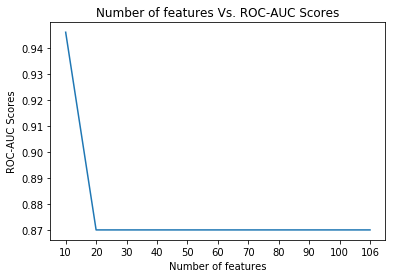

In [99]:
#Line plot showing how roc-auc scores vary with number of features

number_of_features = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '106']
roc_auc_scores = [0.946,  0.87,  0.87,  0.87,  0.87,  0.87,  0.87,  0.87,  0.87,  0.87, 0.87]

plt.plot(number_of_features, roc_auc_scores)
plt.xlabel('Number of features')
plt.ylabel('ROC-AUC Scores')
plt.title('Number of features Vs. ROC-AUC Scores')

## Conclusion

From the analysis above:

- Performed filter feature selection to remove features with no predictive power and reduced the feature space from 51 to 35 thus contributing significantly to dimensionality reduction.
- Performed recursive feature elimination using Random Forests in order to identify the top 10 features that predicts default.
- Analysed the ROC-AUC scores by implementing a k-Nearest Neighbour classifier in order to identify the best-N number of features to use for the research question 5 which focuses on identifying the best machine learning model that predicts defaults with the highest level of accuracy. 
- The ideal number of features that produces the highest ROC-AUC scores was: **10 features**.

**Creating the file with the top 10 predictors of default**

In [100]:
#Creating a list of top_10 features including the target attribute - 'default'

top_10 = ['loan_amnt', 'int_rate', 'sub_grade', 'issue_d', 'total_rec_int',
       'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'tot_cur_bal', 'default']

In [101]:
df = df[top_10]

In [102]:
df.head()

,loan_amnt,int_rate,sub_grade,issue_d,total_rec_int,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,default
0,5000.0,10.65,6.0,7.0,861.07,0.00,3.0,171.62,2.0,138236.152549,0.0
1,2500.0,15.27,13.0,7.0,435.17,117.08,5.0,119.66,5.0,138236.152549,1.0
2,2400.0,15.96,14.0,7.0,603.65,0.00,4.0,649.91,2.0,138236.152549,0.0
3,10000.0,13.49,10.0,7.0,2209.33,0.00,3.0,357.48,3.0,138236.152549,0.0
4,5000.0,7.90,3.0,7.0,631.38,0.00,3.0,161.03,3.0,138236.152549,0.0


In [103]:
#Converting to dataframe 

df.to_csv('default_prediction.csv')